In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

In [2]:
# import modsim and install if necessary
try:
    from modsim import *
except ImportError:
    print("Download modsim from the course repository at https://github.com/jeffwalton/AE470")

## Universal Time (UT)

See [Universal Time at the U.S. Naval Observatory](https://aa.usno.navy.mil/faq/UT).
*The times of various events, particularly astronomical and weather phenomena, are often given in "Universal Time" (abbreviated UT) which is sometimes referred to, now colloquially, as "Greenwich Mean Time" (abbreviated GMT). The two terms are often used loosely to refer to time kept on the Greenwich meridian (longitude zero), five hours ahead of Eastern Standard Time. Times given in UT are almost always given in terms of a 24-hour clock.*

*In the most common civil usage, UT refers to a time scale called "Coordinated Universal Time" (abbreviated **UTC**), which is the basis for the worldwide system of civil time. This time scale is kept by time laboratories around the world, including the U.S. Naval Observatory, and is determined using highly precise atomic clocks. The International Bureau of Weights and Measures makes use of data from the timing laboratories to provide the international standard UTC which is accurate to approximately a nanosecond (billionth of a second) per day. The length of a UTC second is defined in terms of an atomic transition of the element cesium under specific conditions, and is not directly related to any astronomical phenomena.*


## Julian Date

*The Julian date (JD) is a continuous count of days from 1 January 4713 BC (= -4712 January 1), Greenwich mean noon (= 12h UT1). For example, AD 1978 January 1, 0h UT1 is JD 2443509.5 and AD 1978 July 21, 15h UT1, is JD 2443711.125."*
See [Julian Date Formula](https://aa.usno.navy.mil/faq/JD_formula) and [Julian Date Converter](https://aa.usno.navy.mil/data/JulianDate) at the U.S. Naval Observatory.


In [3]:
from math import copysign, trunc

def julian_date( year, month, day, ut ):
    jd = 367*year - trunc((7*(year+trunc((month+9)/12)))/4) + trunc((275*month)/9) + day + 1721013.5 + ut/24 - \
        0.5*copysign(1.0,100*year+month-190002.5) + 0.5
    return jd

In [4]:
# test
print(julian_date(1970,1,1,0))
print(julian_date(1978,1,1,0))
print(julian_date(1978,7,21,15))
print(julian_date(1877,8,11,7.5))

2440587.5
2443509.5
2443711.125
2406842.8125


## Computing Sidereal Time

![greenwich sidereal time](images/greenwich_sidereal_time.jpg)

See [Computing Approximate Sidereal Time at the U.S. Naval Observatory](https://aa.usno.navy.mil/faq/GAST).
*Sidereal time is a system of timekeeping based on the rotation of the Earth with respect to the fixed stars in the sky. Specifically, it is the measure of the hour angle of the vernal equinox. If the hour angle is measured with respect to the mean equinox, mean sidereal time is being measured. When the measurement is made with respect to the meridian at Greenwich, the time is referred to as Greenwich mean sidereal time (GMST).*

*Sidereal time is a function of both the rotation of the Earth on its axis and its motion about the Sun. Because the Earth's rotation rate is not constant the input needs to be split into two parts: Terrestrial Time, TT, and Universal Time, UT1. The input times are represented as Julian dates.*

[Sidereal Time calculator](https://aa.usno.navy.mil/data/siderealtime)


In [5]:
def gmst(jdut, ut):
    jd0 = jdut - ut/24
    dut = jd0 - 2451545.0 
    gmst = (18.697375 + 24.065709824279*dut) % 24
    return gmst

In [7]:
# test
gmst(julian_date(2024,2,24,7.5),7.5)

10.225170228630304

In [8]:
# for degrees multiply by 15
gmst(julian_date(2024,2,24,0),0)*15

153.37755342945457

In [ ]:
# example usage
theta = gmst(julian_date(2024,2,24,0),0)*15 + w_earth*t

## ECI to ECEF

The orbit equations that we have been working with give the satellite's geocentric position in Earth Centered Inertial (ECI) coordinates. See [Earth-centered inertial](https://en.wikipedia.org/wiki/Earth-centered_inertial).

The ground track longitude and latitude will be calculated from the position vector of the satellite in the Earth Centered, Earth Fixed (ECEF) frame, fixed to the rotating earth.  Obtaining ECEF coordinates is a simple coordinate transformation about the rotational axis (Z-axis) of the earth. See [Earth-centered, Earth-fixed coordinate system](https://en.wikipedia.org/wiki/Earth-centered,_Earth-fixed_coordinate_system).

\begin{equation}
\mathbf{R}_3(\theta) = 
 \begin{bmatrix}
  \cos{\theta} & \sin{\theta} & 0 \\
  -\sin{\theta} & \cos{\theta} & 0 \\
  0 & 0 & 1 
 \end{bmatrix}
\end{equation}

where $ \theta = \theta_0 + \omega_{earth}( t - t_0 ) $ and $ \omega_{earth} = 7.2921159 × 10^{−5} $ radians/second.  In this case, $ t_0 $ is the time when the prime meridian (Greenwich meridian) lines up with the ECI X-axis (vernal equinox direction).  $ \theta $ is also known as the Greenwich Sidereal Time (or Greenwich Hour Angle).  See [Sidereal Time at the U.S. Naval Observatory](https://aa.usno.navy.mil/data/siderealtime).  

\begin{equation}
\vec{\mathbf{r}}_{ECEF} = \mathbf{R}_{ECEF,ECI}(\theta) \vec{\mathbf{r}}_{ECI}
\end{equation}


In [ ]:
def R3(theta):
    c = np.cos(theta)
    s = np.sin(theta)
    return np.matrix([[ c, s, 0],
                      [-s, c, 0],
                      [0, 0, 1]])

In [ ]:
def eci2ecef(vec_eci,gst):
    return R3(gst)@vec_eci

## Longitude and Latitude (right ascention and declination)

Longitude ($lon$, $\lambda$) is the angle measured in the equator eastward from the prime meridian to the meridian of the object. Latitude ($lat$, $\phi$) is the angle measured from the equator to the object. See [Geocentric Latitude](https://en.wikipedia.org/wiki/Latitude#Geocentric_latitude).
<br>
![Latitude and Longitude](images/300px-Latitude_and_longitude_graticule_on_an_ellipsoid.svg.png)

<br>

On the celestial sphere the corresponding coordinates are called right ascension ($RA$, $\alpha$) and declination ($dec$, $\delta$).
<br>
![celestial sphere](images/celestial_sphere.jpg)

In [9]:
def vec_to_latlon(vec):
    r = vector_mag(vec)
    l = vec.x/r
    m = vec.y/r
    n = vec.z/r
    lat = np.arcsin(n)
    if m>0:
        lon = np.arccos(l/np.cos(lat))
    else:
        lon = 2*np.pi - np.arccos(l/np.cos(lat))
    return lon, lat


Test with:
### Curtis, Example 4.1, page 187

It the position vector of the International Space Station in the geocentric equatorial frame is $ \vec{\mathbf{r}} = -5368 \hat{\mathbf{i}} - 1784 \hat{\mathbf{j}} + 3691 \hat{\mathbf{k}} $ km, what are its longitude and latitude? 


In [12]:
r_vec = Vector(-5368,-1784, 3691)
lon, lat = vec_to_latlon(r_vec)
print(np.rad2deg(lon),np.rad2deg(lat))

198.38370037548617 33.12454287112769


## Ground Tracks



Please run `pip install basemap` in your command window with the AE470 virtual environment activated.


In [50]:
from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib.pyplot as plt

def ground_track(ground_tracks, plot_title='Ground Track'):
    """
    ground_tracks is a list of DataFrames of lon lat ground tracks
    For example, [[orbit1.lon, orbit1.lat], [orbit2.lon, orbit2.lat]]
    """
    plt.rcParams['figure.figsize'] = [12, 10]
    
    # llcrnrlat,llcrnrlon,urcrnrlat,urcrnrlon
    # are the lat/lon values of the lower left and upper right corners
    # of the map.
    # lat_ts is the latitude of true scale.
    # resolution = 'c' means use crude resolution coastlines.
    m = Basemap(projection='merc',llcrnrlat=-85,urcrnrlat=85,\
                llcrnrlon=-180,urcrnrlon=180,lat_ts=20,resolution='l')
    m.drawcoastlines()
    m.fillcontinents(color='coral',lake_color='aqua',alpha=0.6)
    # draw parallels and meridians.
    m.drawparallels(np.arange(-90.,91.,30.))
    m.drawmeridians(np.arange(-180.,181.,60.))
    m.drawmapboundary(fill_color='aqua') 
    plt.title(plot_title)

    for gt in ground_tracks:
        lon, lat = m(gt.lon, gt.lat)
        m.plot(lon, lat)

    plt.show()



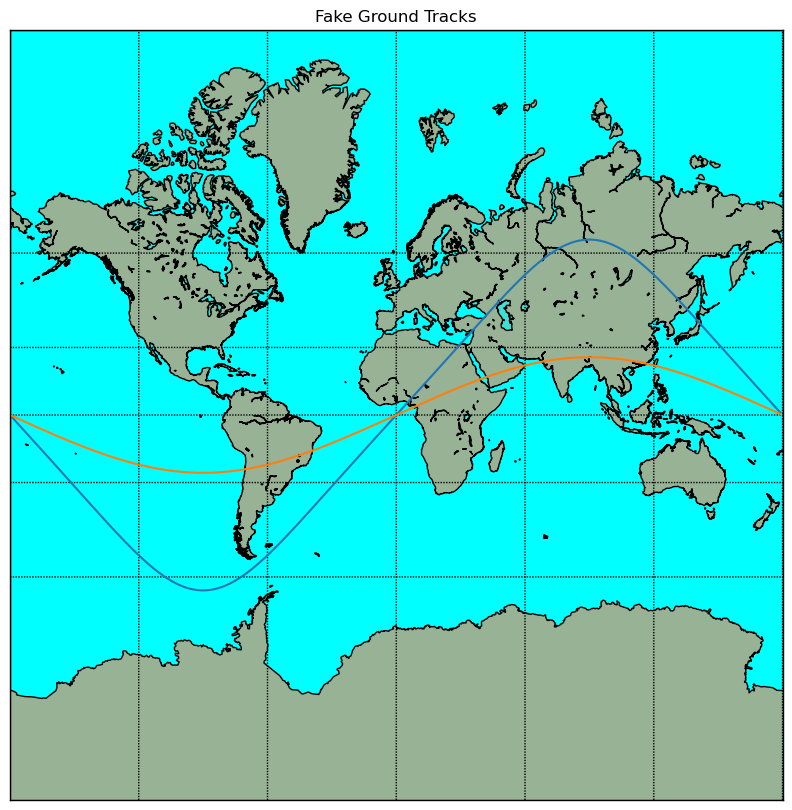

In [52]:
# test with fake data
import pandas as pd
fake_lon = np.arange(-180.,180.,1.0)
fake_lat = np.sin(np.arange(-np.pi,np.pi,np.deg2rad(1.0)))

gt1 = pd.DataFrame({'lon': fake_lon, 'lat':fake_lat*63.0})
gt2 = pd.DataFrame({'lon': fake_lon, 'lat':fake_lat*26.0})
ground_tracks = [gt1,
                 gt2]

ground_track(ground_tracks, 'Fake Ground Tracks')

YouTube video: [Groundtracks Introduction](https://www.youtube.com/watch?v=lKt080AywZ4)

## Sky Plot

![Sky plot example](images/VisualizeSatelliteTrajectoriesInSkyplotExample_01.png)
from [Matlab skyplot](https://www.mathworks.com/help/nav/ref/skyplot.html).

![ENU topocentric](images/ECEF_ENU_Longitude_Latitude_relationships.png)
from [proj.org](https://proj.org/en/9.3/operations/conversions/topocentric.html).




In [1]:
def ecef2enu(X_vec, lon_obs, lat_obs):
    clon = np.cos(lon_obs)
    clat = np.cos(lat_obs)
    slon = np.sin(lon_obs)
    slat = np.sin(lat_obs)
    F = np.matrix([[ -slon, -slat*clon, clat*clon],
                   [  clon, -slat*slon, clat*slon],
                   [     0,       clat,      slat]])
    return F.transpose @ X_vec

def azi_ele(enu_vec):
    E = enu_vec.x
    N = enu_vec.y
    U = enu_vec.z
    azi = np.arctan(E/N)
    ele = np.arctan(U/np.sqrt(N**2 + E**2))
    return azi,ele
    

## Two-Line Orbital Elements (TLE)

*A two-line element set (TLE, or more rarely 2LE) or three-line element set (3LE) is a data format encoding a list of orbital elements of an Earth-orbiting object for a given point in time, the epoch. Using a suitable prediction formula, the state (position and velocity) at any point in the past or future can be estimated to some accuracy.*

See [Two-line element set from Wikipedia](https://en.wikipedia.org/wiki/Two-line_element_set)

## References

R.R. Bate, D.D. Mueller, J.E. White, W.W. Saylor; Fundamentals of Astrodynamics, Dover, 2nd Ed, 2020.  

H.D. Curtis; Orbital Mechanics for Engineering Students; Butterworth-Heinemann, 4th Ed, 2021.  
[Matlab code from Curtis text](https://github.com/jorgepiloto/astrodynamics/tree/master)

A.H.J. de Ruiter, C.J. Damaren, J.R. Forbes; Spacecraft Dynamics and Control: An Introduction; Wiley, 2013.

[Matlab - Orbital Mechanics Library](https://www.mathworks.com/matlabcentral/fileexchange/13439-orbital-mechanics-library)
